# Neural Fitted Q (NFQ)

In many real tasks the state space is combinatorial and enormous and the problem is not just the memory needed for large tables, but the time needed to fill them accurately. It is necessary **to generalize**. Generalization from examples has already been extensively studied, we need to combine reinforcement learning methods with machine learning.

The Cart-pole environment is a classic in reinforcement learning. The state space is low dimensional but continuous. Training is fast, yet still somewhat challenging, and function approximation can help.

Its state space is comprised of four variables: 

- position on the track (x-axis) with a range from –2.4 to 2.4; 
- velocity along the track (x-axis) with a range from –inf to inf; 
- angle with a range of –40 degrees to 40 degrees; 
- velocity at the tip with a range of –inf to inf.

There are two available actions in every state: 

- action 0 applies a –1 force to the cart (push it left)
- action 1 applies a +1 force to the cart (push it right)

The cart reach a terminal state if: 

- the angle is more than 12 degrees away from the vertical position; 
- the center is more than 2.4 units from the center of the track; 
- the episode count reaches 500 time steps. 

The reward function is +1 for every time step.

In [1]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [2]:
print(cartpole.observation_space.shape[0])

4


In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state = env.reset()[0]
        done = False
        steps = 0;
        while not done and steps < max_steps:
            if(pi is None):
                action = np.random.choice((0, 1))
            else:
                action = pi.select_action(agent.model, state)
            
            state, reward, done, _, _ = env.step(action)
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            time.sleep(0.001)

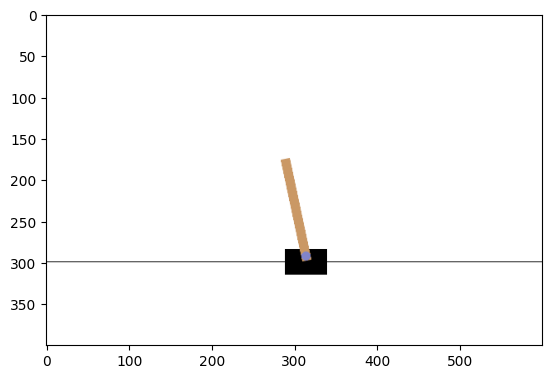

In [4]:
show_policy(cartpole, None, n_episodes=5, max_steps=500)

We can implent a function approximator that take as input the state and provide in output the Q-values for all the actions of that state as a fully connected network using the PyTorch library:

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the output layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
            
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))

        # finally, pass for the output layer
        x = self.output_layer(x)
        
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions)
        new_states = torch.from_numpy(new_states)
        rewards = torch.from_numpy(rewards)
        is_terminals = torch.from_numpy(is_terminals)
        return states, actions, new_states, rewards, is_terminals

We need to decide how to balance the exploration-exploitation trade-off: almost any technique would work fine. To keep things simple, we’re going to use an epsilon-greedy strategy:

In [6]:
class EGreedyStrategy():
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        # get a random number..
        if np.random.rand() > self.epsilon:
            # ...if greater than epsilon, act greedily
            action = np.argmax(q_values)
        else: 
            # ...otherwise, act randomly
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = (action != np.argmax(q_values))
        return action

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [7]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        q_values = model(state).detach()
        q_values = q_values.data.numpy().squeeze()
        return np.argmax(q_values)

The full neural fitted Q-iteration (NFQ) algorithm has the following steps:
1. collect E experiences (e.g. 1024 samples)
2. calculate the off-policy TD targets
3. fit the action-value function using MSE and RMSprop
4. repeats steps 2 and 3 K number of times before going back to step 1

In [8]:
import random 
import torch
import torch.optim as optim

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 batch_size, epochs):
        self.env = env
        self.seed = seed
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

We add the 'train' method to the class to manage the training process:

In [9]:
from itertools import count

def train(self, gamma, max_minutes, max_episodes, goal_reward):

    # timing variables
    training_start = time.time()

    self.gamma = gamma

    # stats trackers 
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []        
    self.episode_exploration = []

    # vector to collect the experience
    self.experiences = []

    result = np.empty((max_episodes, 4))
    result[:] = np.nan
        
    training_time = 0

    # train until we either reach the max minutes, the max episodes or the goal mean reward
    for episode in range(1, max_episodes + 1):

        # get the start time of the episode
        episode_start = time.time()

        # reset the episode trackers
        self.episode_reward.append(0.0)
        self.episode_timestep.append(0.0)
        self.episode_exploration.append(0.0)

        # reset the environment before next episode starts
        state, is_terminal = self.env.reset()[0], False
            
        # interact with the environment until the episode is done
        for step in count():

            # interact with environment using the exploration policy
            # and collect the experience batch
            state, is_terminal = self.interaction_step(state)

            # if the experience is enough, then optimize the model 
            if len(self.experiences) >= self.batch_size:

                # load the experiences as tensors for training
                experiences = np.array(self.experiences, dtype=object)
                batches = [np.vstack(sars) for sars in experiences.T]
                experiences = self.model.load(batches)

                # optimize the model for a number of epochs
                for _ in range(self.epochs):
                    self.optimize_model(experiences)
                    
                # reset the experience batch
                self.experiences.clear()

            if is_terminal:
                break
            
        # timing stuff
        episode_elapsed = time.time() - episode_start
        self.episode_seconds.append(episode_elapsed)
        training_time += episode_elapsed

        # episode steps count
        total_step = int(np.sum(self.episode_timestep))

        # evaluate the learned policy after the episode
        evaluation_score, _ = self.evaluate()
        self.evaluation_scores.append(evaluation_score)
            
        # average stats over some recent episodes
        mean_100_train_reward = np.mean(self.episode_reward[-100:])
        std_100_train_reward = np.std(self.episode_reward[-100:])
        mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
        std_100_eval_score = np.std(self.evaluation_scores[-100:])

        # report results
        result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
        # check max episodes, max minutes and goal achievement criteria
        total_elapsed = time.time() - training_start
        reached_max_minutes = total_elapsed >= max_minutes * 60
        reached_max_episodes = episode >= max_episodes
        reached_goal_mean_reward = mean_100_eval_score >= goal_reward
        training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
        # informative print logging  
        debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
        debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
        print(debug_message, end='\r', flush=True)

        # conclude training if we have met any of the stopping conditions 
        if training_is_over:
            print(debug_message)
            if reached_max_minutes: print('--> reached_max_minutes ')
            if reached_max_episodes: print('--> reached_max_episodes ')
            if reached_goal_mean_reward: print('--> reached_goal_mean_reward ')
            break
        
    # evaluate the final policy
    final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
    return result, final_eval_score, final_eval_std, training_time

NFQ.train = train

We write a method to manage the optimization of the network using the experiences collected:

In [10]:
def optimize_model(self, experiences):
        
    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_terminals = experiences

    # get the batch size
    batch_size = len(is_terminals)
        
    # get the values of the Q-function at next state
    # remember to detach, we need to treat these values as constants 
    q_sp = self.model(next_states).detach()
        
    # get the max value of the next state
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        
    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp
        
    # finally, we get the current estimate of Q(s,a)
    q_sa = self.model(states).gather(1, actions)

    # create the errors
    td_errors = q_sa - target_q_sa
        
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

NFQ.optimize_model = optimize_model


We manage the interaction step using the exploration strategy and collect experience in a batch:

In [11]:
def interaction_step(self, state):

        # interact with environment using the exploration policy
        action = self.train_strategy.select_action(self.model, state)

        # collect an experience tuple as usual
        new_state, reward, is_terminal, is_truncated, info = self.env.step(action)
        
        # a failure is defined as follows
        is_failure = is_terminal and not is_truncated

        # collect the experience and store it in the batch 
        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)

        # update episode stats
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        
        return new_state, is_terminal

NFQ.interaction_step = interaction_step

Finally, we add a method to evaluate the learned policy using a greedy strategy:

In [12]:
def evaluate(self, n_episodes=1):

    # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment
        s = self.env.reset()[0]

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the exploitation policy
            a = self.eval_strategy.select_action(self.model, s)

            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

             # add the reward to the return of the episode
            rs[-1] += r

            if d or t:
                break
        
    return np.mean(rs), np.std(rs)

NFQ.evaluate = evaluate

We can apply the NFQ algorithms to the Cart-pole environment:

In [13]:
gamma = 1.00

max_minutes = 20
max_episodes = 10000
goal_reward = 475

batch_size = 1024
epochs = 40

nfq_results = []
best_agent = None
best_eval_score = float('-inf')

# create the environment without the render mode
cartpole = gymnasium.make('CartPole-v1')

for seed in (12, 34, 56, 78, 90):     
    print('Training started...')
    
    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    cartpole.np_random = np.random.Generator(np.random.PCG64(seed))
    
    # create the model, optimizer and strategy
    nS, nA = cartpole.observation_space.shape[0], cartpole.action_space.n
    model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
    train_strategy = EGreedyStrategy(epsilon=0.5)
    eval_strategy = GreedyStrategy()
    
    # create the agent
    agent = NFQ(cartpole, model, optimizer, train_strategy, eval_strategy, batch_size, epochs)

    # train the agent
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)

    # save the results the best agent
    nfq_results.append(result)
    if score > best_eval_score:
        best_eval_score = score
        best_agent = agent
    
    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))
        
nfq_results = np.array(nfq_results)

Training started...
episode 2337, steps 165324, avg eval score 477.5 (+/- 055.1)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 28.01s training time

Training started...
episode 2401, steps 256652, avg eval score 475.1 (+/- 051.2)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 471.91±39.91 in 42.91s training time

Training started...
episode 3156, steps 345346, avg eval score 476.4 (+/- 048.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 483.65±28.21 in 59.48s training time

Training started...
episode 3032, steps 349583, avg eval score 476.4 (+/- 050.9)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 499.55±2.33 in 61.78s training time

Training started...
episode 2679, steps 327974, avg eval score 475.2 (+/- 053.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 496.61±10.95 in 57.93s training time



NFQ is not a state-of-the-art solution, however in a somewhat simple environment as the cart-pole, it shows a decent performance:

In [14]:
nfq_max_steps, nfq_max_train_reward, nfq_max_eval_score, nfq_max_time = np.max(nfq_results, axis=0).T
nfq_min_steps, nfq_min_train_reward, nfq_min_eval_score, nfq_min_time = np.min(nfq_results, axis=0).T
nfq_mean_steps, nfq_mean_train_reward, nfq_mean_eval_score, nfq_mean_time = np.mean(nfq_results, axis=0).T
nfq_episodes = np.arange(len(nfq_mean_steps))

We can save results on a file to compare with other algorithms in future lectures:

In [15]:
np.savez('nfq_results',
         nfq_max_steps = nfq_max_steps, nfq_max_train_reward = nfq_max_train_reward, nfq_max_eval_score = nfq_max_eval_score, nfq_max_time = nfq_max_time,
         nfq_min_steps = nfq_min_steps, nfq_min_train_reward = nfq_min_train_reward, nfq_min_eval_score = nfq_min_eval_score, nfq_min_time = nfq_min_time,  
         nfq_mean_steps = nfq_mean_steps, nfq_mean_train_reward = nfq_mean_train_reward, nfq_mean_eval_score = nfq_mean_eval_score, nfq_mean_time = nfq_mean_time)


We can plot the training reward:

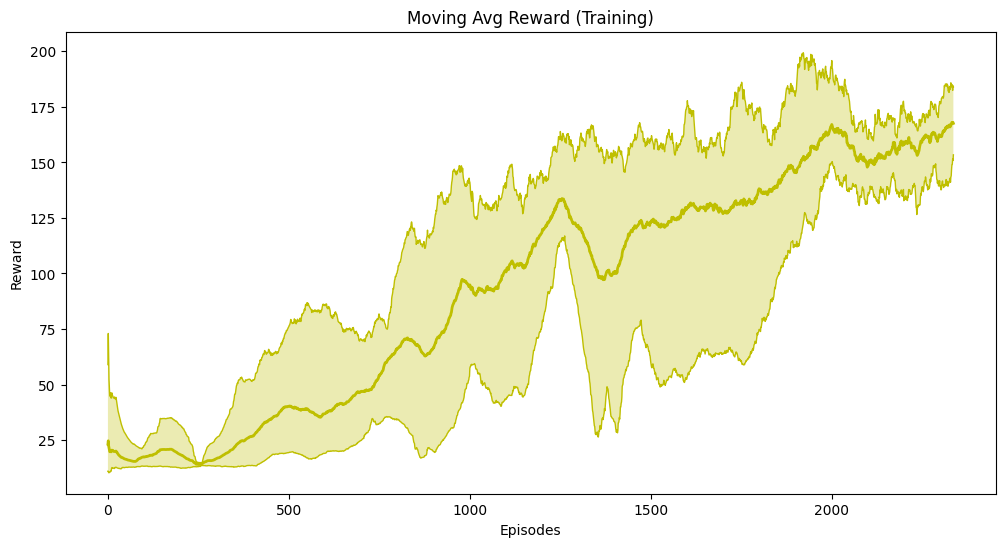

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.show()

Notice that the training reward never reaches the max of 500 reward per episode. The reason is we are using an epsilon of 0.5. Having such a high exploration rate helps with finding more accurate value functions, but it shows worse performance during training.

Plotting the reward during evaluation steps shows the best performance we can obtain from the agent:

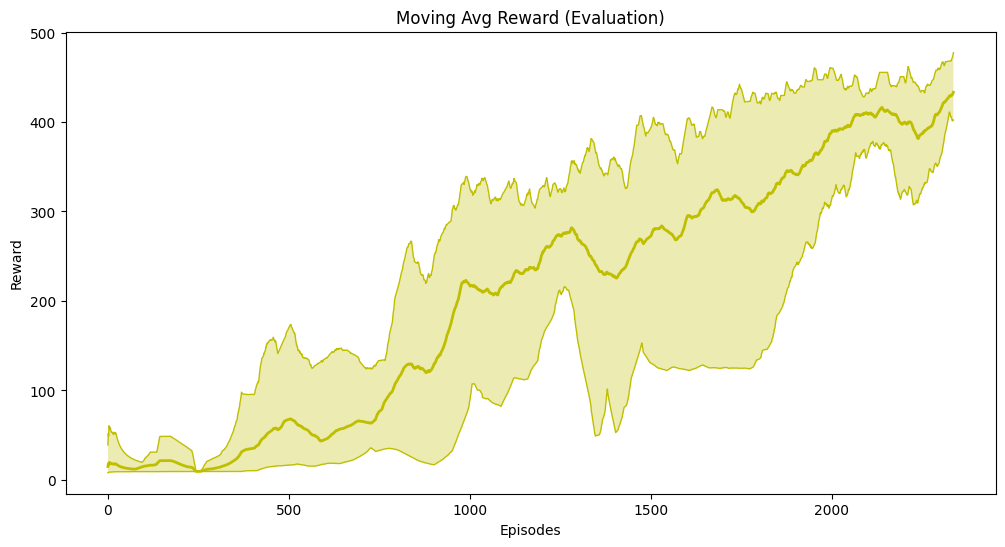

In [17]:
plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.show()

The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly:

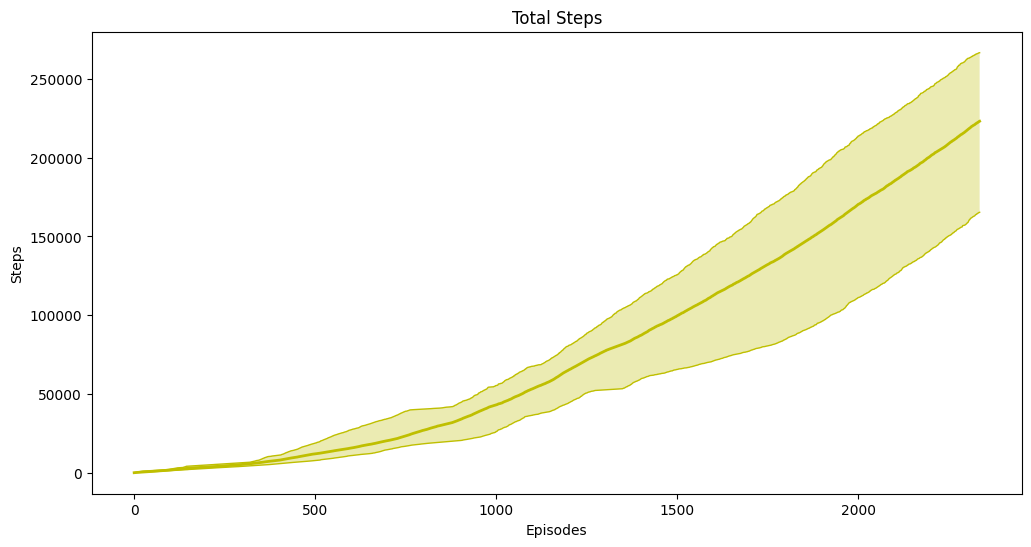

In [18]:
plt.figure(figsize=(12,6))

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')

plt.plot(nfq_max_steps, 'y', linewidth=1)
plt.plot(nfq_min_steps, 'y', linewidth=1)
plt.plot(nfq_mean_steps, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_steps, nfq_max_steps, facecolor='y', alpha=0.3)

plt.show()

We can see how time NFQ takes on average to pass the environment:

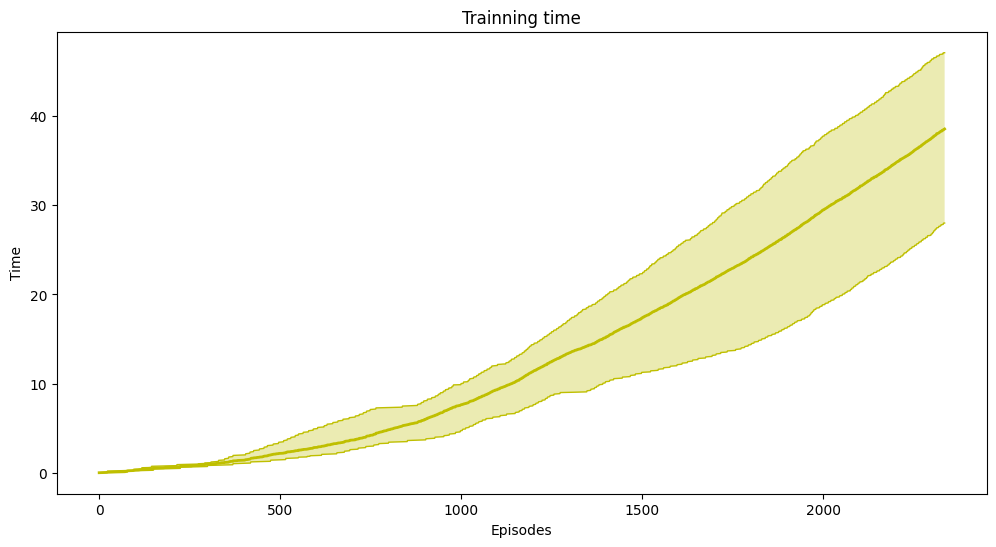

In [19]:
plt.figure(figsize=(12,6))

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.show()

We can display the trained model behavior:

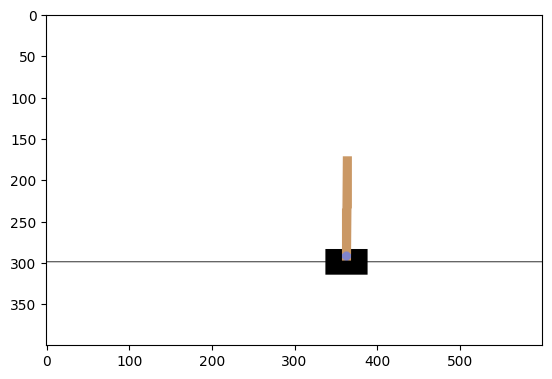

In [20]:
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")
show_policy(cartpole, best_agent.eval_strategy, n_episodes=1, max_steps=200)